In [5]:
import math
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp
import time
import pandas
import matplotlib.pyplot as plt
import random

In [6]:
def haversine(coord1, coord2):
    lat1, lon1 = coord1
    lat2, lon2 = coord2
    R = 6367

    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = (math.sin(dlat / 2) ** 2 +
    math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2) ** 2)
    c = 2* math.asin(math.sqrt(a))
    return R * c

In [7]:
denver_airport = ("Denver Airport", (39.8571391027151, -104.67682422525337))

resorts = [
    denver_airport,
    ("Vail", (39.60634275473704, -106.35502534758554)),
    ("Beaver Creek", (39.601840601122596, -106.53163266107806)),
    ("Breckenridge", (39.48111351412133, -106.07307234912773)),
    ("Keystone", (39.58186424927065, -105.94362588806374)),
    ("A-Basin", (39.634289749362566, -105.8714993899124)),
    ("Eldora", (39.937376571357305, -105.58271078989766)),
    ("Canyons", (40.685834569379516, -111.55630231684529)),
    ("Heavenly", (38.9288904430737, -119.90519040528994)),
    ("Northstar", (39.26481569676928, -120.13316534575092)),
    ("Kirkwood", (38.68503611762454, -120.06520941879404)),
    ("Afton Alps", (44.85782048122588, -92.78779547430095)),
    ("Mt. Brighton", (42.5410196899345, -83.81160753394613)),
    ("Verbier", (46.09708737973264, 7.227272162830475)),
    ("Arlberg", (47.129520437009155, 10.263859008628906)),
    ("The 3 Valleys", (45.34154189826385, 6.586552723873957)),
    #("Hakuba", (36.70953229239828, 137.8375449672692)),
    #("Stowe", (44.52780341219657, -72.7840507492601)),
    #("Whistler", (50.11510834832886, -122.94864740290662)),
    #("Falls Creek", (-36.86255837930399, 147.28225756981914)),
    #("Park City", (40.645235089321, -111.49619780528646)),
    #("Crested Butte", (38.899637981886706, -106.96593646157648)),
    #("Stevens Pass", (47.74592800076063, -121.08961359219548)),
    #("Hunter", (42.20309380867143, -74.22469054753368)),
    #("Okemo", (43.411331909263986, -72.72848172578584))



]

In [8]:
drive_cost_per_mile = 0.58
flight_variable_cost = 0.14
flight_base_fee = 50
threshold_miles = 400
lodging_per_stop = 120

def km_to_miles(km):
    return km / 1.60934

In [9]:
n = len(resorts)
cost_matrix = []
for i in range(n):
    row = []
    for j in range(n):
        if i == j:
            row.append(0)
        else:
            dist_km = haversine(resorts[i][1], resorts[j][1])
            dist_miles = km_to_miles(dist_km)

            if dist_miles > threshold_miles:
                transport_cost = (
                    flight_base_fee + dist_miles * flight_variable_cost
                )
            else:
                transport_cost = dist_miles * drive_cost_per_mile

            lodging_cost = lodging_per_stop if j != 0 else 0

            total_cost = transport_cost + lodging_cost

            row.append(int(round(total_cost)))
    cost_matrix.append(row)

In [10]:
def held_karp(cost):
    N = len(cost)
    C = {}

    for k in range(1, N):
        C[(1 << k, k)] = cost[0][k]

    for s in range(2, N):
        for mask in (m for m in range(1 << N)
                     if bin(m).count("1") == s and not (m & 1)):
            for j in range(1, N):
                if not (mask & (1 << j)): continue
                prev = mask ^ (1 << j)
                best = float('inf')
                for k in range(1, N):
                    if k == j or not (prev & (1 << k)): continue
                    val = C[(prev, k)] + cost[k][j]
                    if val < best:
                        best = val
                C[(mask, j)] = best
    full_mask = ((1 << N) - 1) ^ 1
    ans = float('inf')
    for j in range(1, N):
        val = C[(full_mask, j)] + cost[j][0]
        if val < ans:
            ans = val
    return ans

In [11]:
manager = pywrapcp.RoutingIndexManager(n, 1, 0)
routing = pywrapcp.RoutingModel(manager)

In [12]:
def cost_callback(from_idx, to_idx):
    return cost_matrix[manager.IndexToNode(from_idx)][manager.IndexToNode(to_idx)]

In [13]:
cb_idx = routing.RegisterTransitCallback(cost_callback)
routing.SetArcCostEvaluatorOfAllVehicles(cb_idx)

In [14]:
search_params = pywrapcp.DefaultRoutingSearchParameters()
search_params.first_solution_strategy = (
    routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
)

search_params.local_search_metaheuristic = (
    routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH
)

search_params.time_limit.seconds = 30

In [15]:
solution = routing.SolveWithParameters(search_params)

In [16]:
if solution:
    idx = routing.Start(0)
    route = []
    or_cost = 0
    while not routing.IsEnd(idx):
        route.append(resorts[manager.IndexToNode(idx)][0])
        prev = idx
        idx = solution.Value(routing.NextVar(idx))
        or_cost += routing.GetArcCostForVehicle(prev, idx, 0)
    route.append(resorts[manager.IndexToNode(idx)][0])

    print("OR Tools route:", "->".join(route))
    print(f"OR Tools trip cost: ${or_cost:,}")
else:
        print("No Solution found!")

hk_cost = held_karp(cost_matrix)
print(f"Held-Karp optimal cost: ${hk_cost:,}")

OR Tools route: Denver Airport->Eldora->A-Basin->Keystone->Breckenridge->Vail->Beaver Creek->Kirkwood->Heavenly->Northstar->Canyons->Arlberg->Verbier->The 3 Valleys->Mt. Brighton->Afton Alps->Denver Airport
OR Tools trip cost: $4,002
Held-Karp optimal cost: $4,002


In [17]:
def time_or_tools(sub_cost):
    mgr = pywrapcp.RoutingIndexManager(len(sub_cost), 1, 0)
    r = pywrapcp.RoutingModel(mgr)
    def cb(i, j):
        return sub_cost[mgr.IndexToNode(i)][mgr.IndexToNode(j)]
    tidx = r.RegisterTransitCallback(cb)
    r.SetArcCostEvaluatorOfAllVehicles(tidx)
    params = pywrapcp.DefaultRoutingSearchParameters()
    params.first_solution_strategy = routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC

    t0 = time.perf_counter()
    r.SolveWithParameters(params)
    return time.perf_counter() - t0

def time_hk(sub_cost):
    t0 = time.perf_counter()
    held_karp(sub_cost)
    return time.perf_counter() - t0


In [18]:
N = len(cost_matrix)
reps = 5
sizes = list(range(5, N+1, 3))

records = []
for s in sizes:
    for _ in range(reps):
        others = random.sample(range(1,N), s-1)
        idxs = [0] + others

        sub = [[cost_matrix[i][j] for j in idxs] for i in idxs]
        t_or = time_or_tools(sub)
        t_hk = time_hk(sub)

        records.append({
            "size": s,
            "or_time": t_or,
            "hk_time": t_hk
        })

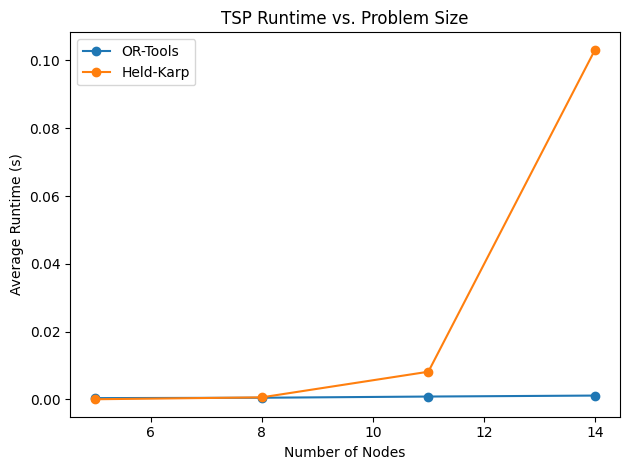

In [19]:
df = pandas.DataFrame(records)
agg = df.groupby("size").mean().reset_index()

plt.figure()
plt.plot(agg["size"], agg["or_time"], marker = "o", label = "OR-Tools")
plt.plot(agg["size"], agg["hk_time"], marker = "o", label = "Held-Karp")
plt.xlabel("Number of Nodes")
plt.ylabel("Average Runtime (s)")
plt.title("TSP Runtime vs. Problem Size")
plt.legend()
plt.tight_layout()
plt.show()